# OMP Machine Learning project

<img src="https://github.com/alphacentaury-github/NPSS2020/blob/master/NN_AB.jpg" width="600">

* The project aims to construct a neural network which generate optical model potential parameters.
* The main idea is to construct two neural networks and train them separately. Because optical potential parameters are not physical observavbles, one cannot directly train the NN to generate optical potential parameters. 
* One neural network(NN-A) takes inputs such as (kinematic information), (Optical potential parameters), (angle). And output of NN is (differential cross section)
* The other neural network (NN-B) takes inputs (projectile mass and charge),(target mass and charge),(projectile energy),(angle). And the output of NN are (Optical potential parameters). 
* __The first NN-A will be trained with pseudo-data generated by usual reaction codes.__ Thus, NN-A would acts as a pseudo-Shrodinger equation solver. Once the trainning is done, we will fix the NN's parameters.
* The NN-B will be connected in front of NN-A. So that combined NN has ooutput of (differential cross section). 
  __The combined neural network will be trained with experimental data. Because NN-A is fixed, the training will determine the parameters of NN-B only.__ 
* Once the training of combined NN is done, we detach the NN-A and NN-B. Then, __NN-B will act like a optical potential generator.__
* __Why not just train one NN with experimental data?__ It is possible to train neural network directly for the relation between kinematic information and cross section. However, it may be not good idea.
* One reason is that experimental data may be not so many to reliably train the NN. In our model, training of NN-A can have as many pseudo data as we want.  Assumption is the training of optical model parameter would require less number of experimental data. 
* The other reason is that optical potential is a useful tool for reaction theory.
* Another reason is to extrapolate the optical potential for the unknown systems. Simple extrapolation of NN is usually not reliable. But, assumption is that the extrapolation of optical potential may be more reliable. 
* Final reason is that such NN will be a complete black box. Here the model may be slightly pale.
* __The assumption on the optical potential shape is not correct!__ 
* It is obvious that assumption on the optical model parameter will significantly reduce the model space for a possible optical potential. However, it is useful in practical application.  
* __What's different from usual global optical potential approach?__ 
* Only possible difference is that we are using NN for the relation between kinematics and optical potential model parameter. Usual approach requires a guess for a fitting function. Hope is that NN is complex enough to catch physically meaningful relation.
* __Why combine two NN? Can't we just use reaction code to compute cross section from optical potential?__ 
* The training of NN is efficient when one can use __backpropagation method__ which is done automatically in the NN libraries. Backpropagation with nuemrical differentiation will be not efficient for NN training. 

## simple NN-A toy problem

* Let us start from the construction of NN-A. At the moment, let us not consider details of the actual input and output but focus on making a skeleton of the code.
* In actual work, we have to decide how the input and output are prepared(normalization, file structure and so on.). Also, the structure of neural networks. 

### import required packages and functions

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# convert integer to array 
def integer_to_bin_array(N,dim_b=8):
    """ Convert integers into dim_b bits  binary
    """
    bin_str = bin(N)[2:] # to binary string 
    if len(bin_str) > dim_b :
        raise ValueError('{} is too large to be {} bits'.format(N,dim_b))
    bin_str=bin_str.zfill(dim_b) #padding zero 
    bin_array=[float(j) for j in bin_str] 
    return bin_array

### global options 

In [4]:
#---model related
opt_model_load = False   # whether to read model parameters from file
opt_model_save = False   # whether to save the model parameters to file
opt_model_train = True   # whether to train/update the model parameters 
model_filename = 'my_model.h5' # filename to save models
#---training data related (Because preprocessing can be different.) 
opt_data_load = False     # whether to load pre-prepared data sets
opt_data_save = False    # whether to save pre-prepared data sets
dataset_filenames = ['train_dataset','test_dataset']

## test problem 

* Let's start from a simple toy case.
* First, we generate data for a fixed projectile/target and optical potential. 
* Only variation is on the energy. 
* In other words, we want to simulate the energy/angle dependence of the cross section by using NN. 

__sigma=f(Elab,theta)__

i.e, AP,ZP,AT,ZT,V,rv,av,W,rw,rc are constants

* In fact, the data is for the ratio of differential cross section to Rutherford cross section. 

### Generate/Read data

* generate_data.py : runs Fresco code for the angular distribution for various input parameters
* __One have to check__ what kind of data are generated from the generate_data.py.

In [6]:
import generate_data as gd
if opt_data_load :
    train_dataset= pd.read_pickle('./train_data.pkl')
    test_dataset= pd.read_pickle('./test_data.pkl')
    print('Data loaded from file')
else:
    data = gd.make_dictionary(AP_list = [1], ZP_list = [1],
        AT_list = [12], ZT_list = [6],
        Elab_list = np.arange(8.0,21.0,1.0),
        V_list = [10.0], rv_list = [1.25], av_list = [0.65],
        W_list = [5.0], rw_list = [1.25], aw_list = [0.65],
        rc_list = [1.2],
        save_file=True,save_path='./fresco_data/',
        plot_graph=True)      
    (train_dataset,test_dataset) = gd.prepare_NN_input(data,
              q_randomize_index=True,               
              train_frac=0.8)  
    #----save into file
    train_dataset.to_pickle('./train_data.pkl')
    test_dataset.to_pickle('./test_data.pkl')
    print('Data generated and saved to file')

Data loaded from file


In [16]:
train_stats=train_dataset.describe()
train_stats

,AP,ZP,AT,ZT,Elab,V,rv,av,W,rw,aw,rc,theta,sigma
count,1872.0,1872.0,1872.0,1872.0,1872.000000,1872.0,1872.00,1.872000e+03,1872.0,1872.00,1.872000e+03,1.872000e+03,1872.000000,1872.000000
mean,1.0,1.0,12.0,6.0,13.993590,10.0,1.25,6.500000e-01,5.0,1.25,6.500000e-01,1.200000e+00,88.414578,1.992714
std,0.0,0.0,0.0,0.0,3.753347,0.0,0.00,8.884157e-16,0.0,0.00,8.884157e-16,1.310413e-14,51.760231,1.679152
min,1.0,1.0,12.0,6.0,8.000000,10.0,1.25,6.500000e-01,5.0,1.25,6.500000e-01,1.200000e+00,0.010000,0.009814
25%,1.0,1.0,12.0,6.0,11.000000,10.0,1.25,6.500000e-01,5.0,1.25,6.500000e-01,1.200000e+00,44.000000,0.634375
50%,1.0,1.0,12.0,6.0,14.000000,10.0,1.25,6.500000e-01,5.0,1.25,6.500000e-01,1.200000e+00,87.000000,1.465500
75%,1.0,1.0,12.0,6.0,17.000000,10.0,1.25,6.500000e-01,5.0,1.25,6.500000e-01,1.200000e+00,133.000000,3.126750
max,1.0,1.0,12.0,6.0,20.000000,10.0,1.25,6.500000e-01,5.0,1.25,6.500000e-01,1.200000e+00,179.000000,7.392000


### data preparation/preprocess

* One may want to use only part of the features in the data frame
* Or, one may want to select a certain kinds of data under some condition
* Or, one may scale data to a suitable range (into a range of (-1,1), or use log scale.) 
* For the toy problem, only angle and energy are variables. Thus, preprocess removes other features. 
* For the ratio or cross section, log scale may be reasonable.

In [67]:
#===Preprocess feature and target 
def preprocess_features(data_frame):
    """
    Args:
    data_frame: A Pandas DataFrame expected to contain data
    
    Returns:
    A DataFrame that contains only features to be used for the model, including
    synthetic features.
    
    Note: Synthetic features should be encoded here 
    """
    feature_choices=["Elab","theta"]
    selected_features = data_frame[ feature_choices ]
    processed_features = selected_features.copy() # to make symthetic features 
    # One can create new synthetic feature. or normlize the data 
    return processed_features

def preprocess_targets(data_frame):
    """Prepares target features (i.e., labels) from data set.
    
    Args:
    data_frame: A Pandas DataFrame expected to contain data
    target_feature : target feature    
    
    Returns:
    A DataFrame that contains the target feature.
    """  
    feature_choices=["sigma"]
    # preprocess 
    processed_targets = data_frame[feature_choices]   
    output = pd.DataFrame()
    output['logscale'] = np.log(processed_targets) #logscale
    return output

#### preprocess data and plot

__blue__ are train data
__red__ are test data

train and target are chosen randomly.

In [68]:
train_examples=preprocess_features(train_dataset)
train_labels = preprocess_targets(train_dataset)

test_examples = preprocess_features(test_dataset)
test_labels = preprocess_targets(test_dataset)

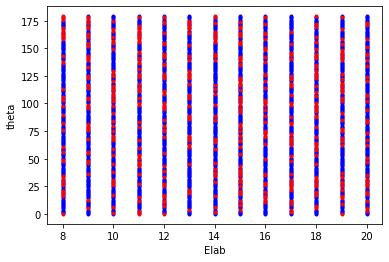

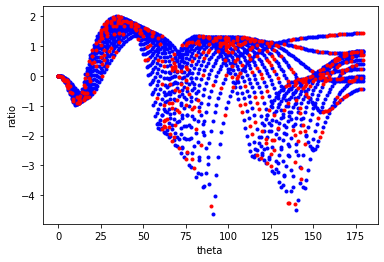

In [71]:
#plot nuclear chart 
# blue are train red are test
plt.figure()
plt.plot(train_examples["Elab"],train_examples["theta"],'b.'
         ,test_examples["Elab"],test_examples["theta"],'r.')
plt.xlabel('Elab');plt.ylabel('theta');
plt.figure()
plt.plot(train_examples["theta"],train_labels["logscale"],'b.'
         ,test_examples["theta"],test_labels["logscale"],'r.')
plt.xlabel('theta');plt.ylabel('ratio');

### Some convenient routines

In [72]:
# print dots per the end of one epoch 
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

#plot history 
def plot_history(history,drop_epoch=0):
  # drop_epoch : remove first a few epochs from the graph   
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MeV]')
  plt.plot(hist['epoch'][drop_epoch:], hist['mean_absolute_error'][drop_epoch:],
           label='Train Error')
  plt.plot(hist['epoch'][drop_epoch:], hist['val_mean_absolute_error'][drop_epoch:],
           label = 'Val Error')
  ymax= np.max(hist['val_mean_absolute_error'][drop_epoch:].to_numpy())
  #plt.ylim([0,5])
  plt.ylim([0,ymax])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MeV^2$]')
  plt.plot(hist['epoch'][drop_epoch:], hist['mean_squared_error'][drop_epoch:],
           label='Train Error')
  plt.plot(hist['epoch'][drop_epoch:], hist['val_mean_squared_error'][drop_epoch:],
           label = 'Val Error')
  ymax= np.max(hist['val_mean_squared_error'][drop_epoch:].to_numpy())  
  plt.ylim([0,ymax])
  plt.legend()
  plt.show()
 

# early stopping callback ise used to regularize the model fitting
# patience is a number of epochs to check early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

def save_history(history,filename): 
    #convert history of fitting into a dictionary and save it 
    import json 
    hist = history.history
    hist['epoch'] = history.epoch 
    for key in hist:
       hist[key] = [float(i) for i in  hist[key]] #conversion because float32 or other is not compatible with pickle 
    #pickle.dump(hist,open(filename,'w')) # save as pickle ?
    json.dump(hist,open(filename,'w')) #save as json?
    return 

### Simple Neural Network Model construction example

Let us create a simple NN which takes two input features (Elab, theta)
and give one label (sigma).

* Here I set a seed for tf.random. So that the model to be reproducible. 
* However, radomization of data is not using tf.random. To reproduce learning, one have to use the same set of data.

In [89]:
import tensorflow as tf

tf.random.set_seed(123456) # to make the initial model to be reproducible 

def construct_model():
    inputs = tf.keras.Input(shape=(2,)) #input array 
    x = tf.keras.layers.Dense(20, activation=tf.nn.relu)(inputs)
    x = tf.keras.layers.Dense(20, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(20, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(20, activation=tf.nn.relu)(x)
    outputs = tf.keras.layers.Dense(1, activation=None)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = 'adam'
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model 

#====Build Model====================
model = construct_model()

### test trainning

In [90]:
history = model.fit(train_examples, train_labels , epochs=300,
          batch_size=2,
          validation_split = 0.3, verbose=0,callbacks=[PrintDot()] )


....................................................................................................
....................................................................................................
....................................................................................................

Mean Abloute Error: 0.25463470816612244
Mean Squared Error: 0.1356697678565979


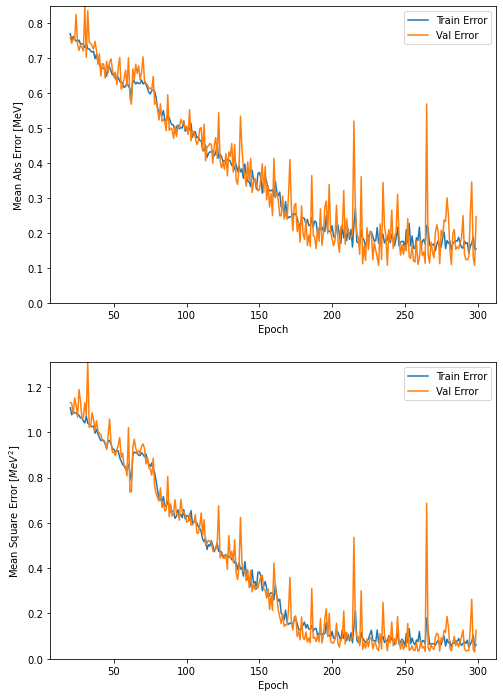

In [91]:
#['mean_absolute_error', 'mean_squared_error']
loss,mae,mse =  model.evaluate(test_examples.values,test_labels.values,verbose=0)
print('Mean Abloute Error:', mae)
print('Mean Squared Error:', mse)
#history 

hist = pd.DataFrame(history.history)

hist['epoch'] = history.epoch
hist.tail()

plot_history(history,drop_epoch=20)

### check the result of NN

Plot sigma(theta,E=10 MeV) and sigma(theta, E= 15 MeV) 

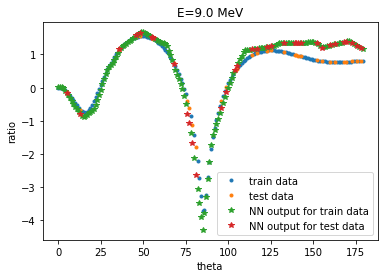

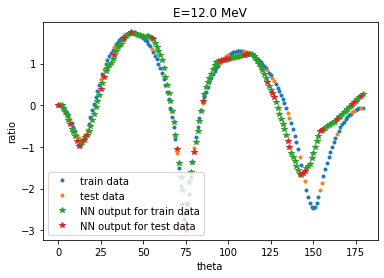

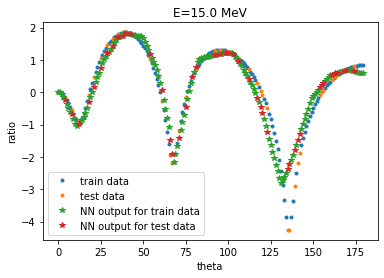

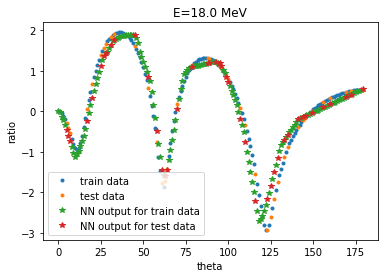

In [92]:
for E_test in [9.0,12.0,15.0,18.0]:
    plt.figure()
    x= train_examples[train_examples['Elab']== E_test]['theta']
    y= train_labels[train_examples['Elab']== E_test]['logscale']
    plt.plot(x,y,'.',label='train data')
    x= test_examples[test_examples['Elab']== E_test]['theta']
    y= test_labels[test_examples['Elab']== E_test]['logscale']
    plt.plot(x,y,'.',label='test data')

    x1= train_examples[train_examples['Elab']== E_test]['theta']
    y1=model.predict(train_examples[train_examples['Elab']== E_test])
    x2=test_examples[test_examples['Elab']== E_test]['theta'] 
    y2=model.predict(test_examples[test_examples['Elab']== E_test])
    plt.plot(x1,y1,'*',label='NN output for train data')
    plt.plot(x2,y2,'*',label='NN output for test data')
    plt.xlabel('theta');plt.ylabel('ratio');
    plt.title('E={} MeV'.format(E_test))
    plt.legend()

### test of interpolation

For energy E=11.5 which is not in the data

ok


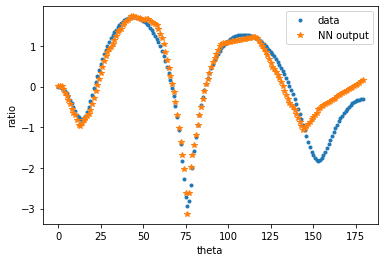

In [112]:
# completely new energy at 25 MeV
data = gd.make_dictionary(AP_list = [1], ZP_list = [1],
        AT_list = [12], ZT_list = [6],
        Elab_list = [11.5],
        V_list = [10.0], rv_list = [1.25], av_list = [0.65],
        W_list = [5.0], rw_list = [1.25], aw_list = [0.65],
        rc_list = [1.2],
        save_file=False,save_path='./fresco_data/',
        plot_graph=False)
(dummy,extra_data) = gd.prepare_NN_input(data,
              q_randomize_index=False,               
              train_frac=0)

extra_x = preprocess_features(extra_data)
extra_Y = preprocess_targets(extra_data)
for E_test in [11.5]:
    plt.figure()
    x= extra_x['theta']
    y= extra_Y['logscale']
    plt.plot(x,y,'.',label='data')

    y1=model.predict(extra_x)
    plt.plot(x,y1,'*',label='NN output')
    plt.xlabel('theta');plt.ylabel('ratio');
    plt.legend()

In [103]:
#----save model 
model.save('SchEq_model_1.h5')

In [109]:
#----load model
from keras.models import load_model
model2= load_model('SchEq_model_1.h5')

## Summary

* As a first step, I tried to use NN to train the energy/angle dependence of the elastic cross section. 
* A simple toy model is tried for the NN-A type. 
* Though not fully satisfactory, the idea seems to work for NN-A. 
* However, the extrapolation of energy beyond would be bad. Thus, one have to train the NN-A for a wide range of energy.
* Construction of model NN-B will be similar. 